In [1]:
import pandas as pd

In [33]:
df = pd.read_csv('c:/Users/Tinanope28/Box/Mini Project 2-3/Licensed_Contractors.csv', low_memory = False)

In [80]:
#Step 1 Create Applicant Table
df['applicantname_phone'] = df['Applicant'].astype(str) + ', ' + df['PhoneNo'].astype(str)

Applicants_Table = df[['Applicant', 'PhoneNo']].drop_duplicates().copy()
Applicants_Table['ApplicantID'] = Applicants_Table.reset_index().index + 1

def create_applicants_dict(df):    
    df['ApplicantKey'] = df['Applicant'].astype(str) + ', ' + df['PhoneNo'].astype(str) 
    return dict(zip(df['ApplicantKey'], df['ApplicantID']))

applicants_dict = create_applicants_dict(Applicants_Table)

Applicants_Table = Applicants_Table.drop(columns=['ApplicantKey']).copy()


In [81]:
#Step 2 Create Description Table
Description_Table = df[['Description', 'Category']].drop_duplicates().copy()
Description_Table['DescriptionID'] = Description_Table.reset_index().index + 1

def create_description_dict(df):
    return dict(zip(df['Category'], df['DescriptionID']))

description_dict = create_description_dict(Description_Table)

In [82]:
#Step 3 Create State Table
State_Table = df[['State']].drop_duplicates().copy()
State_Table['StateID'] = State_Table.reset_index().index + 1

def create_state_dict(df):
    return dict(zip(df['State'], df['StateID']))

state_dict = create_state_dict(State_Table)

In [ ]:
#Step 4 Create Municipality Table

df['municipality_state'] = df['municipality_state'].str.upper()

Municipality_Table= df[['Municipality', 'State', 'municipality_state']].drop_duplicates().copy()

Municipality_Table['Municipality']= Municipality_Table['Municipality'].str.upper()


Municipality_Table = Municipality_Table.reset_index(drop=True)

Municipality_Table['MunicipalityID'] = Municipality_Table.index + 1

def create_municipality_dict(df):
    return dict(zip(df['municipality_state'], df['MunicipalityID']))

municipality_dict = create_municipality_dict(Municipality_Table)

Municipality_Table['StateID'] = Municipality_Table['State'].map(state_dict)

Municipality_Table = Municipality_Table.drop(columns=['municipality_state', 'State']).copy()


In [ ]:
#Step 4 Create Business Table
df.loc[df['BusinessName'].str.upper() == 'NO DATA', 'BusinessName'] = df['Applicant']

Business_Table = df[['BusinessName','Category']].copy()
Business_Table['municipality_state'] = df['municipality_state'].str.upper()

Business_Table['MunicipalityID'] = Business_Table['municipality_state'].map(municipality_dict)
Business_Table['DescriptionID'] = Business_Table['Category'].map(description_dict)

Business_Table.drop(columns=['municipality_state', 'Category'])

Business_Table = Business_Table[['BusinessName', 'MunicipalityID', 'DescriptionID']].drop_duplicates().copy()
Business_Table['BusinessID'] = Business_Table.reset_index().index + 1

def create_business_dict(df):
    return dict(zip(df['BusinessName'], df['BusinessID']))

business_dict = create_business_dict(Business_Table)

In [85]:
#Step 5 Create License Table
License_Table = df[['LicenseNo', 'ExpDate', 'BusinessName', 'applicantname_phone']].copy()
License_Table['BusinessID'] = License_Table['BusinessName'].map(business_dict)
License_Table['ApplicantID'] = License_Table['applicantname_phone'].map(applicants_dict)
License_Table.drop(columns=['BusinessName', 'applicantname_phone'])

License_Table = License_Table[['LicenseNo', 'ExpDate', 'BusinessID','ApplicantID']].drop_duplicates().copy()
License_Table['ExpDate'] = pd.to_datetime(License_Table['ExpDate'], format='%m/%d/%Y')
License_Table['ExpDate'] = License_Table['ExpDate'].dt.strftime('%Y-%m-%d')

License_Table['LicenseID'] = License_Table.reset_index().index + 1

In [ ]:
#Query 1: Which type of license is most frequently issued?
df_1 = pd.merge(License_Table, Business_Table, on = 'BusinessID', how = 'inner')
df_1 = pd.merge(df_1, Description_Table, on = 'DescriptionID', how = 'inner')

df_1 = (df_1.groupby ('Description').size().reset_index(name = 'LicenseCount').sort_values(by = 'LicenseCount', ascending= False))
df_1.reset_index(drop=  True, inplace = True)

df_1

,Description,LicenseCount
0,LIGHT COMMERCIAL CONTRACTOR,834
1,SE 1ST CLASS,616
2,COLLECTION AGENCY,613
3,PLUMBERS JOURNEYMEN,437
4,SE CHIEF,416
5,SE 2ND CLASS,223
6,PLUMBERS MASTER,188
7,HEATING CONTRACTOR,184
8,MASTER ELECTRICIAN,169
9,SUBCONTRACTOR,146


In [87]:
#Query 2: Which applicants have license applications that are missing contact information?
df_2 = pd.merge(License_Table[['LicenseNo', 'BusinessID', 'ApplicantID']], Business_Table[['BusinessName', 'BusinessID']], on = 'BusinessID', how = 'inner')
df_2 = pd.merge(df_2, Applicants_Table, on = 'ApplicantID', how = 'inner')


df_2 = df_2[df_2['PhoneNo'] == 'NO DATA']

df_2 = df_2.sort_values(by = ['BusinessName', 'Applicant'])
df_2 = df_2.drop(columns=['BusinessID','ApplicantID']).copy()

df_2.reset_index(drop = True, inplace = True)
df_2

,LicenseNo,BusinessName,Applicant,PhoneNo
0,LTC24-10066924,3 BROTHERS PAINT CO LLC,ERIC WALTON,NO DATA
1,TTR24-10066522,5T TOWING AND RECOVERY LLC,OMAR TIRADO,NO DATA
2,LTC22-10061715,6 STARS PROPERTY MANAGEMENT INC.,QUENTIN YANCEY,NO DATA
3,LTC25-10068620,716 BROTHERS CONSTRUCTION INC,LUIS MAYANCELA,NO DATA
4,LTC23-10062151,716 CLEANUP & RESTORATION CORP.,AARON REGDOS,NO DATA
...,...,...,...,...
886,CAG11-553953,ZENTA RECOVERIES INC.,ZENTA RECOVERIES INC.,NO DATA
887,LTC11-561369,ZUMBINO CONCRETE CONSTRUCTION LLC,SANTINO CAMPANELLA,NO DATA
888,TCD24-10065997,independent taxi,SHAMSHER CHEEMA,NO DATA
889,CAG24-10067036,knute financial llc,aaron million,NO DATA


In [88]:
#Query 3: Identify applicants whose licenses are due to expire within the next month (May 1st -May 31st).
df_3 = pd.merge(License_Table, Applicants_Table, on = 'ApplicantID', how = 'inner')

df_3 = df_3[(df_3['ExpDate'] >= '2025-05-01') & (df_3['ExpDate'] <= '2025-05-31') & (df_3['PhoneNo'] != 'NO DATA')]
df_3 = df_3[['LicenseNo', 'ExpDate', 'Applicant', 'PhoneNo']]

df_3 = df_3.sort_values(by = 'ExpDate').reset_index(drop=True)
df_3

,LicenseNo,ExpDate,Applicant,PhoneNo
0,STP14-10028086,2025-05-03,RICHARD E DANIELS,(716)835-0345
1,STP19-10050824,2025-05-28,PHILIP ROMA,(716)668-7885
2,SEC23-10062768,2025-05-31,VINCENT ZIOLKOWSKI,(716)425-4891
3,SEC11-539302,2025-05-31,JAMES PEASE,(716)983-8185
4,SEC11-508011,2025-05-31,JOSEPH MANGOLD,(716)393-3861
...,...,...,...,...
92,SEC11-220574,2025-05-31,DAVID ZYDEL,(716)822-0690
93,SE111-220771,2025-05-31,EDWARD J SUMMERS JR,(716)825-7885
94,SEC11-539389,2025-05-31,FRANCISCO SANTIAGO,(716)566-8954
95,SE111-546453,2025-05-31,GREGORY WOODRUFF,(716)390-8115


In [96]:
#Query 4: Which businesses, that hold a Demolition Level 3 license and are based in Buffalo, New York?
df_4 = pd.merge(Business_Table, Municipality_Table, on='MunicipalityID', how='inner')
df_4 = pd.merge(df_4, Description_Table, on='DescriptionID', how='inner')

df_4 = df_4[(df_4['Municipality'].str.upper() == 'BUFFALO') & (df_4['DescriptionID'] == 10)]

df_4 = df_4[['BusinessName', 'Municipality', 'Description']].sort_values(by='BusinessName').reset_index(drop=True)

df_4

,BusinessName,Municipality,Description
0,"ACP BUFFALO, LLC",BUFFALO,DEMOLITION GRADE 3
1,ATLANTIC GARAGES,BUFFALO,DEMOLITION GRADE 3
2,DEVCON US LLC,BUFFALO,DEMOLITION GRADE 3
3,ELLICOTT CONSTRUCTION CO INC,BUFFALO,DEMOLITION GRADE 3
4,FRONTIER INDUSTRIAL CORP,BUFFALO,DEMOLITION GRADE 3
5,GEITER DONE OF WNY INC.,BUFFALO,DEMOLITION GRADE 3
6,HANNAH DEMOLITION INC,BUFFALO,DEMOLITION GRADE 3
7,LEE'S ENVIRONMENTAL SERVICES INC,BUFFALO,DEMOLITION GRADE 3
8,ONTARIO SPECIALTY CONTRACTING,BUFFALO,DEMOLITION GRADE 3
9,TOTAL WRECKING & ENVIRONMENTAL LLC,BUFFALO,DEMOLITION GRADE 3


In [98]:
#Query 5: Identify businesses that hold licenses for both plumbing and heating?
df_5 = pd.merge(Business_Table, Description_Table, on='DescriptionID', how='inner')

df_5 = df_5.drop(columns=['Category']).copy()


df_5 = df_5.groupby('BusinessName')['Description'].agg(lambda x: ', '.join(sorted(set(x)))).reset_index()


df_5 = df_5.rename(columns={'Description': 'LicenseTypes'})
df_5 = df_5[df_5['LicenseTypes'].str.contains('PLUMBERS MASTER', case=False, na=False) &
            df_5['LicenseTypes'].str.contains('HEATING CONTRACTOR', case=False, na=False)]

df_5['LicenseCount'] = df_5['LicenseTypes'].apply(lambda x: len(x.split(',')))
df_5 = df_5.sort_values(by='LicenseCount', ascending=False)

df_5

,BusinessName,LicenseTypes,LicenseCount
3807,SCHMIT PLUMBING & HEATING,"HEATING CONTRACTOR, INACTIVE MASTER PLUMBER, P...",4
1609,GRAND JUDE PLUMBING & HEATING,"HEATING CONTRACTOR, PLUMBERS JOURNEYMEN, PLUMB...",3
673,CEF ENTERPRISES,"HEATING CONTRACTOR, PLUMBERS JOURNEYMEN, PLUMB...",3
3300,PCS PLUMBING & HEATING,"HEATING CONTRACTOR, PLUMBERS JOURNEYMEN, PLUMB...",3
487,BOB'S SERVICES INC,"HEATING CONTRACTOR, PLUMBERS MASTER",2
945,D.V. BROWN & ASSOCIATES INC,"HEATING CONTRACTOR, PLUMBERS MASTER",2
1101,"DELTA P. PLUMBING, HEATING & AIR CONDITIONING","HEATING CONTRACTOR, PLUMBERS MASTER",2
808,COE'S PLUMBING & HEATING,"HEATING CONTRACTOR, PLUMBERS MASTER",2
787,CLEAN WATER MECHANICAL & CONSTRUCTION,"HEATING CONTRACTOR, PLUMBERS MASTER",2
1781,HURON PLUMBING & HEATING,"HEATING CONTRACTOR, PLUMBERS MASTER",2


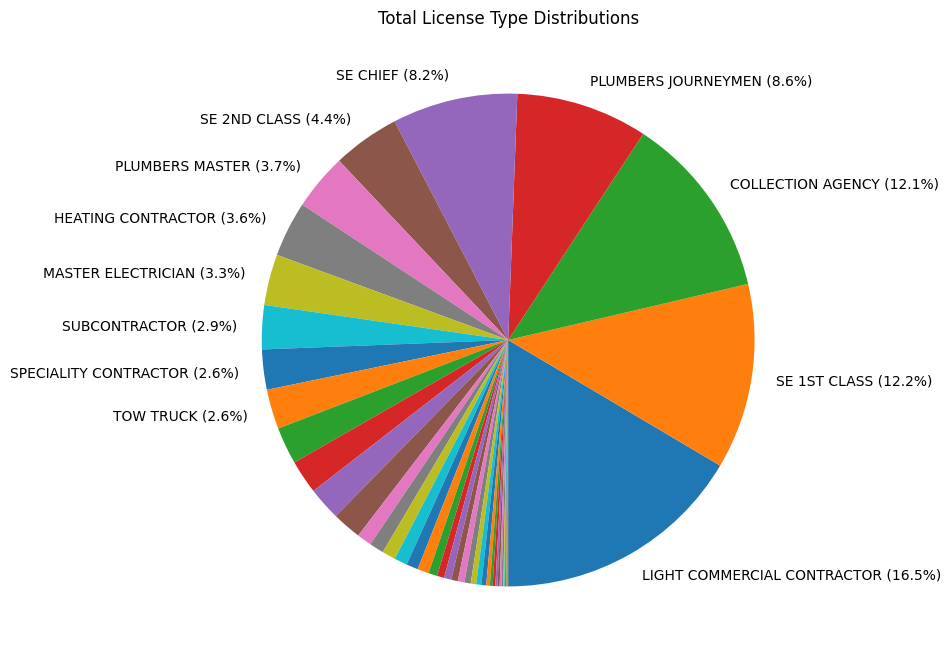

In [99]:
#Figures and plots
import matplotlib.pyplot as plt

LicenseTotal = df_1['LicenseCount'].sum()
df_1['Percentage'] = (df_1['LicenseCount'] / LicenseTotal) * 100

labels = [f"{desc} ({pct:.1f}%)" if pct >= 2.5 else '' for desc, pct in zip(df_1['Description'], df_1['Percentage'])]

plt.figure(figsize = (12, 8))
plt.pie(df_1['LicenseCount'], labels = labels, startangle = 270)

plt.title('Total License Type Distributions')
plt.show()


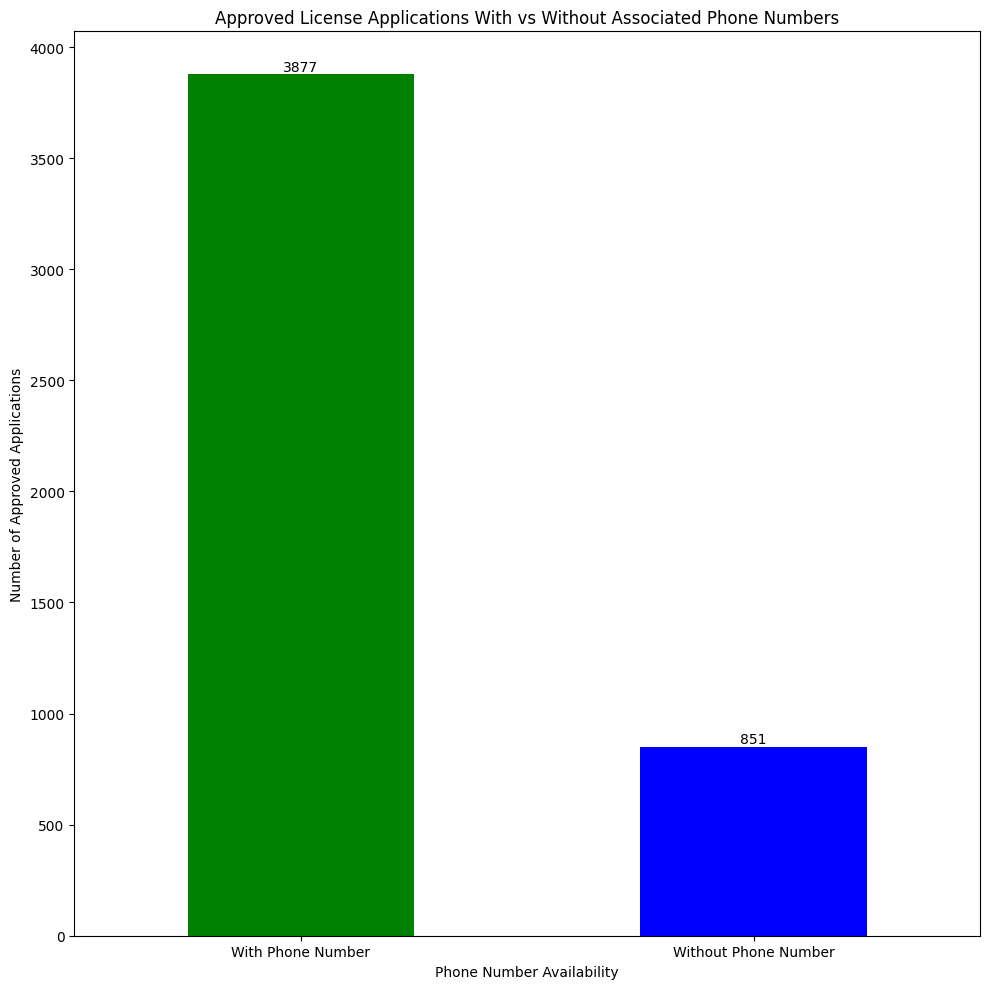

In [ ]:
def phone(phone):
    phone_clean = phone.strip().upper()
    if phone_clean == 'NO DATA':
        return 'Without Phone Number'
    else:
        return 'With Phone Number'

Applicants_Table['PhoneStatus'] = Applicants_Table['PhoneNo'].apply(phone)

phone_counts = Applicants_Table['PhoneStatus'].value_counts()

plt.figure(figsize=(10, 10))
phone_counts.plot(kind = 'bar', color = ['green', 'blue'])

plt.title('Approved License Applications With vs Without Associated Phone Numbers')
plt.xlabel('Phone Number Availability')
plt.ylabel('Number of Approved Applications')
plt.xticks(rotation=0)
plt.tight_layout()

for i, value in enumerate(phone_counts):
    plt.text(i, value + 1, str(value), ha = 'center', va= 'bottom', fontsize = 10)

plt.show()


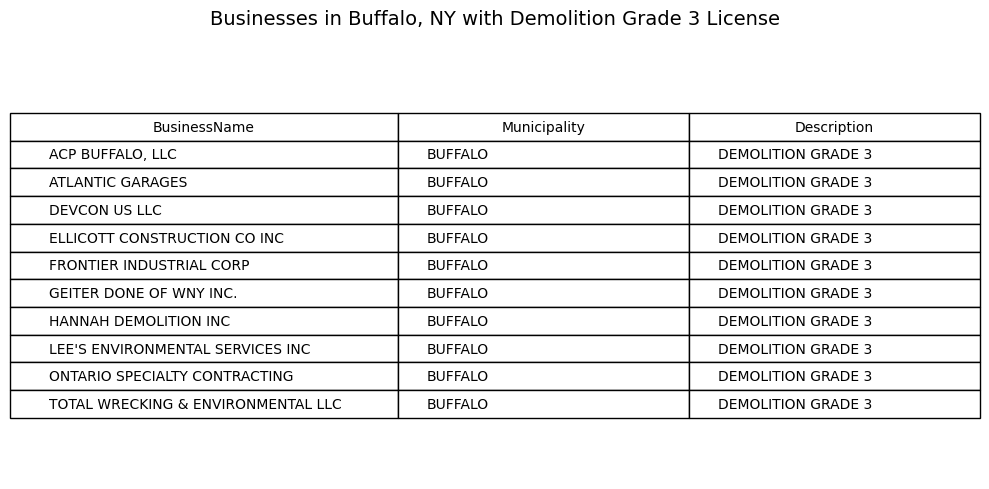

In [ ]:
fig, ax = plt.subplots(figsize=(10, len(df_4) * 0.5))

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText = df_4.values,
                 colLabels = df_4.columns,
                 cellLoc = 'left',
                 loc = 'center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.5, 1.5)


col_widths = [0.4, 0.3, 0.3] 
for i, width in enumerate(col_widths):
    for key, cell in table.get_celld().items():
        if key[1] == i:
            cell.set_width(width)


plt.title("Businesses in Buffalo, NY with Demolition Grade 3 License", pad = 20, fontsize = 14)

plt.tight_layout()
plt.show()


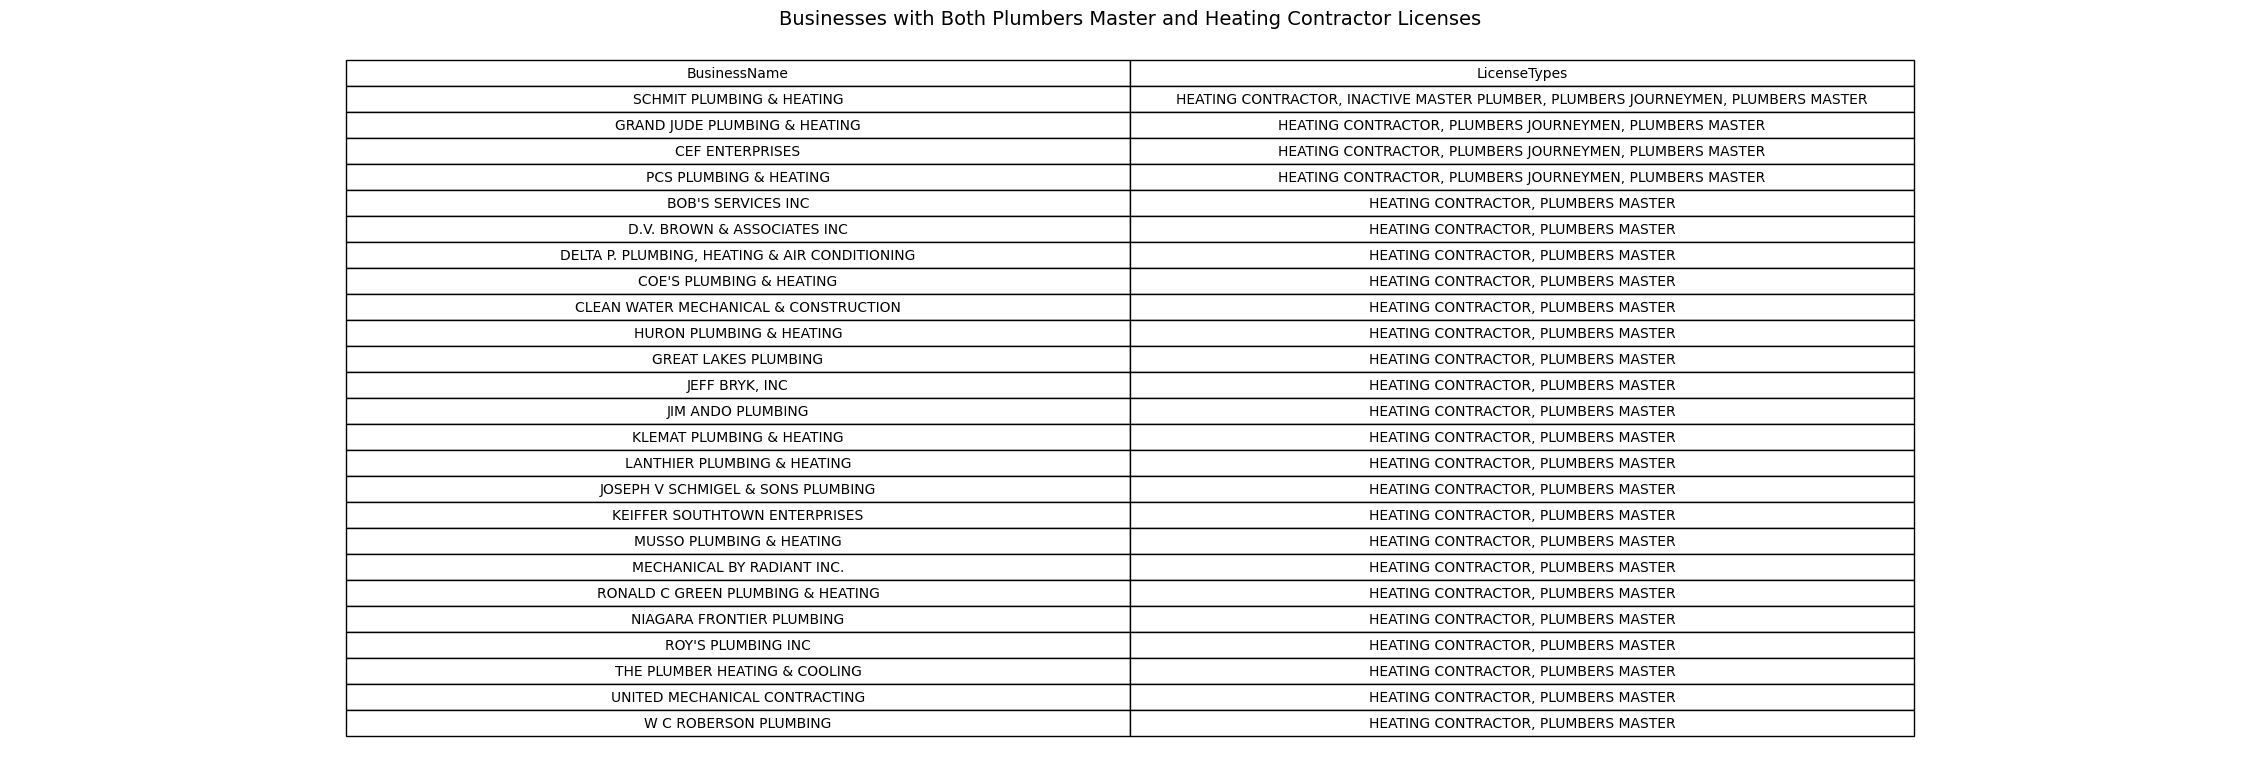

In [ ]:
table_data = df_5[['BusinessName', 'LicenseTypes']].copy()


fig, ax = plt.subplots(figsize=(28,9))  
ax.axis('off')


tbl = plt.table(cellText= table_data.values,
                colLabels= table_data.columns,
                cellLoc='center',
                colLoc= 'center',
                loc= 'center'
                )

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(.7, 1.5)

plt.subplots_adjust(left = 0.1, right= 0.9, top = 0.9, bottom =0.1)

plt.title("Businesses with Both Plumbers Master and Heating Contractor Licenses", fontsize = 14, pad = 10)
plt.show()
